In [1]:
import trig_poly
import dual_certificates
import test_data
import numpy as np
import plt_util
import phase_transition
from matplotlib import pyplot as plt

%matplotlib inline

In [20]:
def kernel_matrix(kernel, support):
    shifted_supports = np.outer(np.ones(N), support) - np.outer(support, np.ones(N))
    return kernel.eval(shifted_supports).real

In [94]:
reload(test_data)
reload(dual_certificates)
reload(trig_poly)

fc = 25
min_separation = 0.9 / fc
N = int(1.0 / min_separation) - 6
m = N

print N, m
print min_separation
print ''

kernel = trig_poly.TrigPoly.dirichlet(fc)

support = test_data.jittered_supports(N, min_separation=min_separation, jitter_factor=2, jitter_ratio=1.0)
sign_pattern = np.identity(N)

21 21
0.036



In [95]:
interpolator = dual_certificates.interpolate_multidim_l2_min(support, sign_pattern, kernel)

In [96]:
K0 = kernel_matrix(kernel, support)
K1 = kernel_matrix(kernel.derivative(), support)
K2 = kernel_matrix(kernel.derivative().derivative(), support)

K0_inv = np.linalg.inv(K0)

beta = np.diag(np.linalg.solve(K0, K1)) / np.diag(K2 - np.dot(K1, np.linalg.solve(K0, K1)))

K0_inv_norm = np.max(np.linalg.svd(K0_inv)[1])
K1_norm = np.max(np.linalg.svd(K1)[1])
D_beta_norm = np.max(np.abs(beta))

In [97]:
kernel_deriv = kernel.derivative()
kernel_deriv_deriv = kernel.derivative().derivative()

ts = np.linspace(0, 1, 1000)
near_second_deriv_bound_values = []
between_bound_values = []

for t in ts:
    k0t = np.array([kernel(t - tj) for tj in support])
    k1t = np.array([-kernel_deriv(t - tj) for tj in support])
    k2t = np.array([kernel_deriv_deriv(t - tj) for tj in support])
    
    k0t_norm = np.linalg.norm(k0t)
    k1t_norm = np.linalg.norm(k1t)
    k2t_norm = np.linalg.norm(k2t)
    
    between_bound_values.append(
        K0_inv_norm * k0t_norm + 
        D_beta_norm * k1t_norm + 
        D_beta_norm * K1_norm * K0_inv_norm * k0t_norm)
    
    near_second_deriv_bound_pos_term = (
        K0_inv_norm * k1t_norm + 
        D_beta_norm * k2t_norm + 
        D_beta_norm * K1_norm * K0_inv_norm * k1t_norm)
    near_second_deriv_bound_neg_term = np.linalg.multi_dot([k0t.T, K0_inv, K0_inv, k2t])[0, 0].real
    
    # Missing error terms from <q(t), q''(t)>
    near_second_deriv_bound_values.append(
        near_second_deriv_bound_neg_term + near_second_deriv_bound_pos_term)

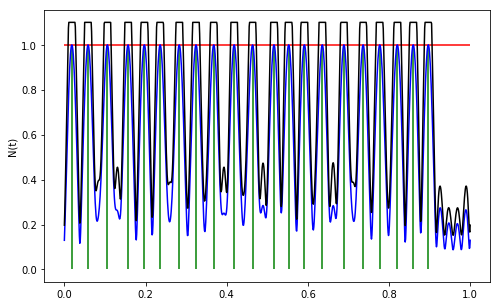

In [98]:
plt.subplots(figsize=(8,5))

plt_util.plot_trig_poly_magnitude(interpolator, points=1000)
plt_util.plot_support_magnitude_lines(support)
plt_util.plot_magnitude_bounds()

plt.plot(ts, np.minimum(1.1, between_bound_values), color='black')

# plt.gca().set_ylim(0.95, 1.01)

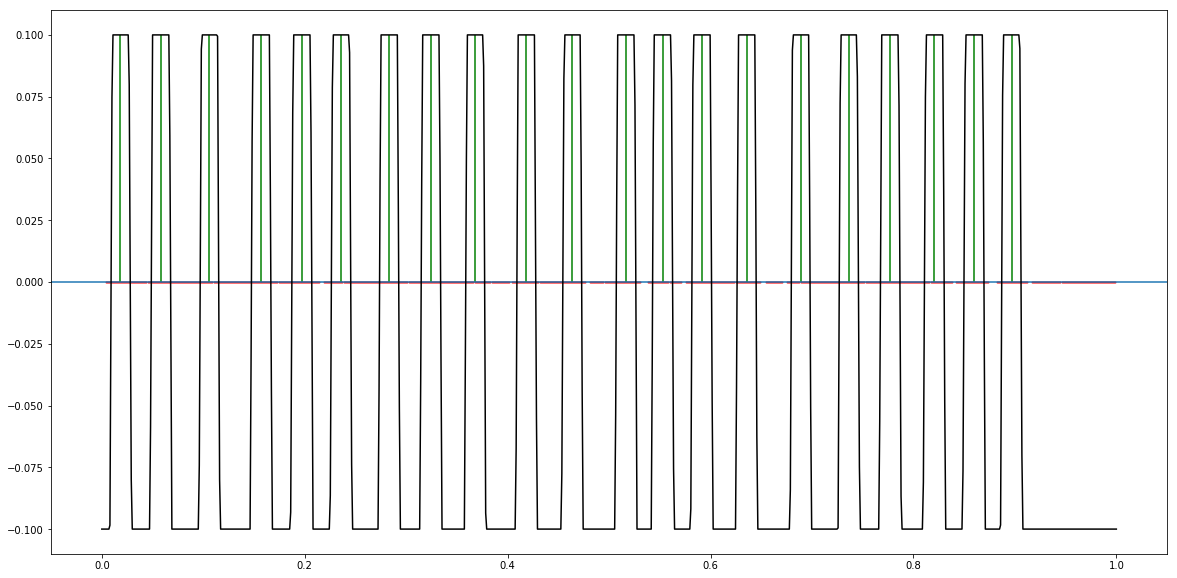

In [99]:
plt.subplots(figsize=(20, 10))

plt.gca().axhline(0.0)
plt.plot(ts, np.maximum(np.minimum(np.array(between_bound_values) - 1.0, 0.1), -0.1), color='black')
# plt.plot(ts, np.maximum(np.minimum(np.array(near_second_deriv_bound_values), 0.5), -0.5), color='red')
plt.scatter(
    ts[np.array(near_second_deriv_bound_values) <= 0.0],
    np.array(near_second_deriv_bound_values)[np.array(near_second_deriv_bound_values) < 0.0] * 0.0, color='red', s=1.0)
plt_util.plot_support_magnitude_lines(support, height=0.1)